In [1]:
%load_ext autoreload
%autoreload 1
%aimport mllib.helpers, mllib.loaders, mllib.plotters

Using TensorFlow backend.


In [2]:
# This helps with joblib "No space left on device" errors
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [128]:
from collections import defaultdict
from pprint import pprint
from time import time
import warnings

from IPython import display
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import describe, kurtosis
import seaborn as sns; sns.set()
from sklearn.cluster import KMeans
from sklearn.decomposition import FastICA, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.random_projection import SparseRandomProjection, johnson_lindenstrauss_min_dim

from mllib.loaders import load_adult, load_mnist
from mllib.helpers import balanced_accuracy, cluster_acc, save_cluster_result, load_cluster_result

In [4]:
dataset = 'adult'
learner_type = 'ANN'
loader_func = load_adult

In [5]:
df = loader_func(preprocess=True)

Dataset shape (30162, 105)
Value composition:
0    0.751078
1    0.248922
Name: target, dtype: float64


In [6]:
scaler = MinMaxScaler()
X = df.drop('target', axis=1)
X = scaler.fit_transform(X)
y = df['target']
n_samples, n_features = X.shape
print(n_samples, n_features)

30162 104


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Clustering (à la carte)

## K-Means

In [7]:
n_clusters = np.hstack((
    np.arange(2, 10),
    np.arange(10, 21, 2),
    np.array([30, 40, 50, 60, 80]),
    np.arange(100, 501, 200),
#     np.array([n_samples/2, n_samples], dtype=np.int)
)).astype(np.int)
print(n_clusters)

[  2   3   4   5   6   7   8   9  10  12  14  16  18  20  30  40  50  60
  80 100 300 500]


In [141]:
km_res = defaultdict(dict)
for k in n_clusters:
    km = KMeans(n_clusters=k,
                random_state=0,
                n_jobs=-1,
               )
    t0 = time()
    km.fit(X)
    t = time() - t0
    y_km = km.predict(X)
    km_res[k]['dist'] = km.inertia_
    km_res[k]['time'] = t
    km_res[k]['sil'] = silhouette_score(X, y_km, random_state=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km_res[k]['ami'] = ami(y, y_km)
    print('done k=%i in %.3f sec' % (k, t))

done k=2 in 0.774 sec
done k=3 in 1.092 sec
done k=4 in 1.721 sec
done k=5 in 1.741 sec
done k=6 in 2.432 sec
done k=7 in 2.526 sec
done k=8 in 2.508 sec
done k=9 in 2.916 sec
done k=10 in 3.675 sec
done k=12 in 4.297 sec
done k=14 in 3.704 sec
done k=16 in 3.849 sec
done k=18 in 4.386 sec
done k=20 in 4.942 sec
done k=30 in 6.921 sec
done k=40 in 8.112 sec
done k=50 in 9.322 sec
done k=60 in 11.603 sec
done k=80 in 14.716 sec
done k=100 in 19.868 sec
done k=300 in 41.197 sec
done k=500 in 62.463 sec


In [142]:
save_cluster_result(km_res, dataset, 'km')

In [90]:
km_res = load_cluster_result(dataset, 'km')

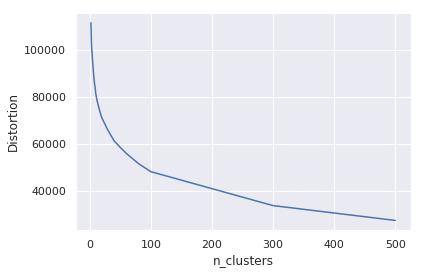

In [143]:
plt.plot(n_clusters, [km_res[k]['dist'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.show()

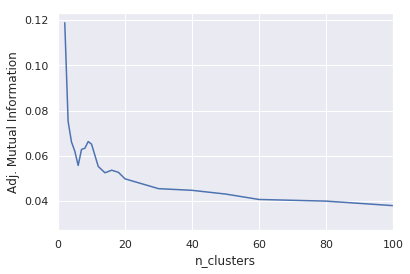

In [92]:
plt.plot(n_clusters, [km_res[k]['ami'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.xlim([0, 100])
plt.show()

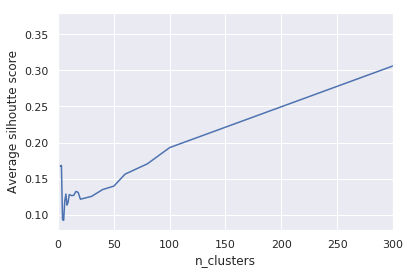

In [94]:
plt.plot(n_clusters, [km_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_clusters')
plt.ylabel('Average silhoutte score')
plt.xlim([0, 300])
plt.show()

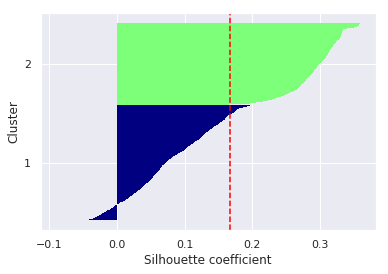

In [146]:
km = KMeans(n_clusters=2,
                random_state=0,
                n_jobs=-1,
               )
y_km = km.fit_predict(X)
cluster_labels = np.unique(y_km)
m_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0,0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / m_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals, 
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color="red",
            linestyle="--") 
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

In [120]:
km2 = KMeans(n_clusters=2,
                random_state=0,
                n_jobs=-1,
               )
y_km = km2.fit_predict(X)

In [125]:
km2_df = pd.DataFrame(data=scaler.inverse_transform(km2.cluster_centers_), columns=df.drop('target', axis=1).columns)

In [130]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(km2_df)

         age         fnlwgt  education-num  capital gain  capital loss  \
0  35.078040  191722.211236       9.970799    596.755521     62.394353   
1  43.124742  187103.844053      10.331269   1782.860092    124.610688   

   hours per week  workclass_Federal-gov  workclass_Local-gov  \
0       38.337318               0.029599             0.068875   
1       44.549627               0.033587             0.068048   

   workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0           0.784039                0.017930                    0.054929   
1           0.675877                0.060267                    0.121804   

   workclass_State-gov  workclass_Without-pay  education_10th  education_11th  \
0             0.044114               0.000512        0.029656        0.042634   
1             0.040019               0.000397        0.023741        0.023741   

   education_12th  education_1st-4th  education_5th-6th  education_7th-8th  \
0        0.015824           0.

In [147]:
from sklearn.metrics.cluster import contingency_matrix
contingency_matrix(y, y_km)

array([[15763,  6891],
       [ 1805,  5703]])

## Expectation Maximization

In [148]:
em_res = defaultdict(dict)
for k in n_clusters:
    gm = GaussianMixture(
        n_components=k,
        random_state=0,
#         n_jobs=-1, # Not supported for GMM?
        n_init=1,
        init_params='kmeans',
#         max_iter=600,
    )
    t0 = time()
    gm.fit(X)
    t = time() - t0
    y_gm = gm.predict(X)
    em_res[k]['bic'] = gm.bic(X)
    em_res[k]['aic'] = gm.aic(X)
    em_res[k]['ll'] = gm.score(X)
    em_res[k]['time'] = t
    em_res[k]['sil'] = silhouette_score(X, y_gm, random_state=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        em_res[k]['ami'] = ami(y, y_gm)
    print('done k=%i in %.3f sec' % (k, t))

done k=2 in 0.946 sec
done k=3 in 1.793 sec
done k=4 in 1.004 sec
done k=5 in 2.546 sec
done k=6 in 3.787 sec
done k=7 in 5.244 sec
done k=8 in 5.499 sec
done k=9 in 6.288 sec
done k=10 in 6.984 sec
done k=12 in 10.571 sec
done k=14 in 10.554 sec
done k=16 in 13.527 sec
done k=18 in 19.373 sec
done k=20 in 16.165 sec
done k=30 in 40.520 sec
done k=40 in 30.545 sec
done k=50 in 60.139 sec
done k=60 in 73.696 sec
done k=80 in 120.336 sec
done k=100 in 140.525 sec
done k=300 in 399.139 sec
done k=500 in 385.975 sec


In [149]:
save_cluster_result(em_res, dataset, 'em')

In [97]:
em_res = load_cluster_result(dataset, 'em')

In [88]:
em2 = KMeans(n_clusters=2,
                random_state=0,
                n_jobs=-1,
               )
y_em = em2.fit_predict(X)
balanced_accuracy(pred=y_em, truth=y)

0.7277025397329043

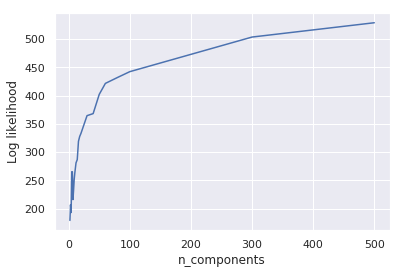

In [131]:
plt.plot(n_clusters, [em_res[k]['ll'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Log likelihood')
plt.show()

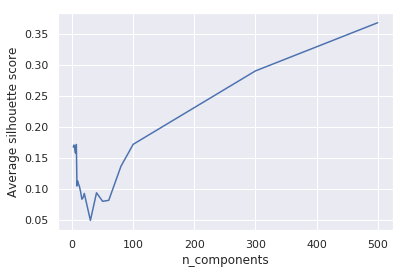

In [132]:
plt.plot(n_clusters, [em_res[k]['sil'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Average silhouette score')
plt.show()

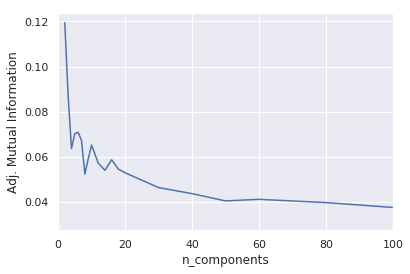

In [133]:
plt.plot(n_clusters, [em_res[k]['ami'] for k in n_clusters])
plt.xlabel('n_components')
plt.ylabel('Adj. Mutual Information')
plt.xlim([0, 100])
plt.show()

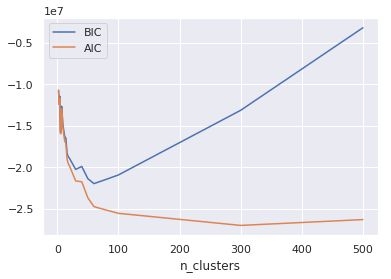

In [153]:
plt.plot(n_clusters, [em_res[k]['bic'] for k in n_clusters], label='BIC')
plt.plot(n_clusters, [em_res[k]['aic'] for k in n_clusters], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()

# Dimensionality Reduction (à la carte)

## PCA

In [135]:
pca = PCA(
    n_components=None,
    random_state=0,
)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

In [139]:
normed = pca.components_[1] / np.linalg.norm(pca.components_[1])
s = pd.Series(normed)
df.drop('target', axis=1).columns[s.abs() > 0.25]

Index(['marital status_Never-married', 'sex_Female', 'sex_Male'], dtype='object')

In [130]:
pca.explained_variance_ratio_

array([1.94022874e-01, 7.92630542e-02, 6.93326971e-02, 5.82801148e-02,
       4.86524841e-02, 4.68292698e-02, 4.19159849e-02, 3.30643881e-02,
       3.06381300e-02, 2.71259882e-02, 2.66376111e-02, 2.52648520e-02,
       2.26125823e-02, 2.07687562e-02, 1.91208583e-02, 1.82123212e-02,
       1.63933297e-02, 1.54912846e-02, 1.28837719e-02, 1.20917033e-02,
       1.13820778e-02, 1.05520271e-02, 1.04137955e-02, 9.77272649e-03,
       9.11451828e-03, 8.31787144e-03, 8.04038654e-03, 7.85127750e-03,
       7.40723050e-03, 7.36350817e-03, 7.11776603e-03, 7.01386912e-03,
       6.55975502e-03, 6.04353814e-03, 4.84299449e-03, 4.43874547e-03,
       4.12474805e-03, 4.00119522e-03, 3.61753407e-03, 3.29097504e-03,
       3.12081763e-03, 3.04651436e-03, 2.87415601e-03, 2.80501466e-03,
       2.52461242e-03, 1.97295258e-03, 1.88885554e-03, 1.84505346e-03,
       1.27381143e-03, 1.16002403e-03, 1.13410095e-03, 1.08991953e-03,
       1.08044530e-03, 9.10838726e-04, 7.88567386e-04, 7.52420368e-04,
      

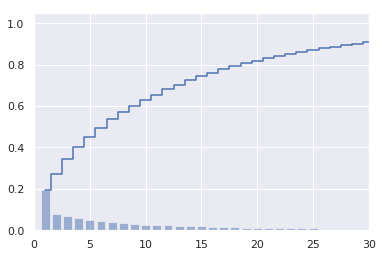

In [131]:
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.step(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), 
        where='mid', label='Cumulative explained variance')
plt.xlim([0, 30])
plt.show()

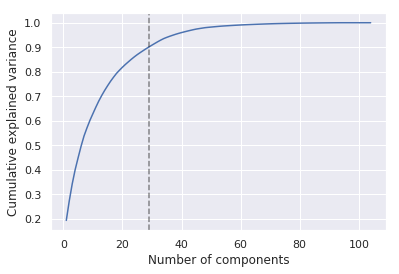

In [241]:
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of components')
plt.axvline(29, linestyle='--', color='k', alpha=0.5)

In [268]:
np.cumsum(pca.explained_variance_ratio_)[18]

0.8065103055587942

In [242]:
pca = PCA(
    n_components=29,
    random_state=0,
)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=29, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

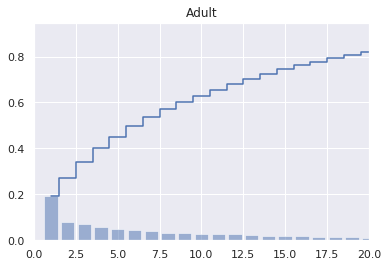

In [245]:
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, 
        align='center', alpha=0.5, label='Individual explained variance')
plt.step(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), 
        where='mid', label='Cumulative explained variance')
plt.xlim([0, 20])
plt.title('Adult')
plt.show()

## ICA

In [203]:
ica = FastICA(
    n_components=10,
    random_state=0,
    max_iter=400,
)
X_tr = ica.fit_transform(X)
kurt_df = pd.DataFrame(kurtosis(X_tr, axis=0), columns=['kurtosis'])
kurt_df.sort_values(by='kurtosis', ascending=False)

,kurtosis
6,2.736727
1,2.426960
9,1.924399
0,1.788207
3,0.901192
4,0.715213
5,0.341749
8,-0.657448
7,-1.418066
2,-1.832945


Kurtosis: higher values indicate the presence of tail extremity, i.e. more data outside of the peak. It's a measure of non-gaussianity and is the basis of ICA.

In [10]:
component_counts = np.hstack((
    np.arange(1, 10),
    np.arange(10, 21, 2),
    np.array([30, 40, 50, 60, 70, 80, 90, 100]),
)).astype(np.int)
total_kurtosis = {}

for component_count in component_counts:
    tmp_ica = FastICA(
        random_state=0,
        n_components=component_count,
    )
    tmp_X_tr = tmp_ica.fit_transform(X)
    total_kurtosis[component_count] = np.abs(kurtosis(tmp_X_tr, axis=0)).sum()

pprint(total_kurtosis)

{1: 1.6196820736461512,
 2: 1.8388659737605686,
 3: 3.4066169477987573,
 4: 3.8930233851467575,
 5: 3.978389120329238,
 6: 5.395703298817876,
 7: 8.194430837987941,
 8: 10.26836363764743,
 9: 11.810515364444713,
 10: 14.742906196965148,
 12: 17.161514843018985,
 14: 26.66861463475488,
 16: 37.69165474110732,
 18: 51.20098075124055,
 20: 72.58517595171222,
 30: 257.279893383158,
 40: 659.7648489806338,
 50: 1588.5716364542868,
 60: 3680.557265693858,
 70: 8073.508726975205,
 80: 17177.683235050856,
 90: 34636.88167368669,
 100: 100305.46402125277}


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


[]

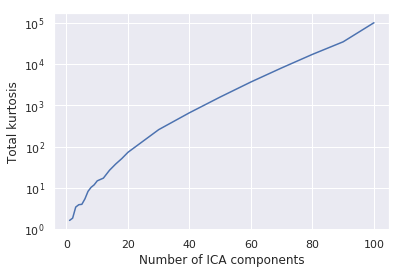

In [26]:
pd.Series(total_kurtosis).plot()
plt.ylabel('Total kurtosis')
plt.xlabel('Number of ICA components')
plt.semilogy()

In [213]:
ica10 = FastICA(
    random_state=0,
    n_components=10,
)
X_tr10 = ica10.fit_transform(X)
kurt_df10 = pd.DataFrame(kurtosis(X_tr10, axis=0), columns=['kurtosis'])
kurt_df10.sort_values(by='kurtosis', ascending=False)

,kurtosis
6,2.736727
1,2.426960
9,1.924399
0,1.788207
3,0.901192
4,0.715213
5,0.341749
8,-0.657448
7,-1.418066
2,-1.832945


In [229]:
normed = ica10.components_[6] / np.linalg.norm(ica10.components_[6])
np.set_printoptions(suppress=True)
normed.astype(np.float)
s = pd.Series(normed)
df.drop('target', axis=1).columns[s.abs() > 0.1]

Index(['race_Asian-Pac-Islander', 'race_Black', 'race_White',
       'country_United-States'],
      dtype='object')

In [230]:
normed = ica10.components_[1] / np.linalg.norm(ica10.components_[1])
np.set_printoptions(suppress=True)
normed.astype(np.float)
s = pd.Series(normed)
df.drop('target', axis=1).columns[s.abs() > 0.1]

Index(['workclass_Self-emp-not-inc', 'education_Bachelors',
       'occupation_Adm-clerical', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Prof-specialty',
       'occupation_Sales'],
      dtype='object')

## Randomized Projections

In [246]:
rp = SparseRandomProjection(
    random_state=0
)
rp.fit(X)

ValueError: eps=0.100000 and n_samples=30162 lead to a target dimension of 8840 which is larger than the original space with n_features=104

In [249]:
eps = np.linspace(0, 1.0, 10)
eps[0] = 0.01
eps[-1] = 0.99
n_samples = X.shape[0]
n_component_bounds = johnson_lindenstrauss_min_dim(n_samples, eps)

In [250]:
n_component_bounds

array([830684,   7218,   1961,    954,    593,    424,    334,    283,
          256,    247])

In [103]:
component_counts = np.array([1, 2, 10, 20, 30, 50, 75, 100]).astype(np.int)

In [142]:
rp = SparseRandomProjection(
        random_state=0,
        n_components=1,
        eps=None
    )
rp.fit(X)
rp_components = rp.components_
rp_components.shape
# for _ in range(10):
#     rp = SparseRandomProjection(
#         random_state=0,
#         n_components=50,
#         eps=None
#     )
    
#     np.hstack()

(1, 104)

## LDA

In [265]:
lda = LDA(
    n_components=None,
)
X_tr = lda.fit_transform(X, y)
X_tr.shape

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(30162, 1)

In [266]:
describe(X_tr)

DescribeResult(nobs=30162, minmax=(array([-2.91158993]), array([6.98082992])), mean=array([0.]), variance=array([1.58752589]), skewness=array([0.73078538]), kurtosis=array([0.93895498]))

Text(0.5, 0, 'Number of components')

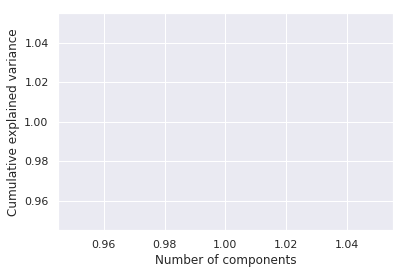

In [260]:
n_lda_components = lda.explained_variance_ratio_.shape[0]
plt.plot(range(1, n_lda_components + 1), np.cumsum(lda.explained_variance_ratio_))
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of components')
# plt.axvline(29, linestyle='--', color='k', alpha=0.5)

# Dimensionality reduction plus Clustering

## PCA

In [17]:
component_counts = [2]
# component_counts = [1, 10, 20, 30]
pca_km_results = {}

for cc in component_counts:
    tmp_pca = PCA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_pca.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0,
            n_jobs=-1,
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
        tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    pca_km_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset,'km', 'pca%i' % cc)

Doing 2 components
done k=2 in 0.106 sec
done k=3 in 0.108 sec
done k=4 in 0.167 sec
done k=5 in 0.190 sec
done k=6 in 0.238 sec
done k=7 in 0.304 sec
done k=8 in 0.322 sec
done k=9 in 0.467 sec
done k=10 in 0.678 sec
done k=12 in 0.820 sec
done k=14 in 0.838 sec
done k=16 in 1.194 sec
done k=18 in 1.349 sec
done k=20 in 1.594 sec
done k=30 in 2.641 sec
done k=40 in 3.233 sec
done k=50 in 4.303 sec
done k=60 in 5.143 sec
done k=80 in 6.845 sec
done k=100 in 8.809 sec
done k=300 in 24.385 sec
done k=500 in 35.946 sec


In [112]:
test_pca = PCA(n_components=2)
x_tr_test = test_pca.fit_transform(X)
test_cluster = KMeans(n_clusters=2, n_jobs=-1)
clusters_test = test_cluster.fit_predict(x_tr_test)

In [118]:
print(x_tr_test.shape, clusters_test.shape)
print(np.hstack((x_tr_test, clusters_test[:, None])))

(30162, 2) (30162,)
[[ 0.51168699 -0.56966437  0.        ]
 [-1.18664074  0.39011883  1.        ]
 [ 0.32723624 -0.44912486  0.        ]
 ...
 [ 0.9423339   0.86797368  0.        ]
 [ 0.53229596 -1.04652853  0.        ]
 [ 0.1060333   1.21380504  0.        ]]


In [76]:
pca_gm_results = {}
component_counts = [10, 20, 30]

for cc in component_counts:
    tmp_pca = PCA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_pca.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
        tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    pca_gm_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset, 'em', 'pca%i' % cc)

Doing 10 components
done k=2 in 0.090 sec
done k=3 in 0.249 sec
done k=4 in 0.344 sec
done k=5 in 0.218 sec
done k=6 in 0.424 sec
done k=7 in 0.505 sec
done k=8 in 0.903 sec
done k=9 in 0.919 sec
done k=10 in 1.053 sec
done k=12 in 1.214 sec
done k=14 in 1.803 sec
done k=16 in 2.840 sec
done k=18 in 3.506 sec
done k=20 in 2.999 sec
done k=30 in 6.140 sec
done k=40 in 6.338 sec
done k=50 in 13.650 sec
done k=60 in 13.375 sec
done k=80 in 11.314 sec
done k=100 in 20.363 sec
done k=300 in 35.664 sec
done k=500 in 40.432 sec
Doing 20 components
done k=2 in 0.162 sec
done k=3 in 0.202 sec
done k=4 in 0.294 sec
done k=5 in 0.327 sec
done k=6 in 0.389 sec
done k=7 in 0.430 sec
done k=8 in 0.895 sec
done k=9 in 0.879 sec
done k=10 in 1.055 sec
done k=12 in 3.016 sec
done k=14 in 4.940 sec
done k=16 in 3.956 sec
done k=18 in 7.497 sec
done k=20 in 9.439 sec
done k=30 in 12.619 sec
done k=40 in 13.771 sec
done k=50 in 16.610 sec
done k=60 in 18.894 sec
done k=80 in 25.258 sec
done k=100 in 26.93

In [143]:
component_counts = [1, 2, 10, 20, 30]
pca_km_results = {cc: load_cluster_result(dataset, 'km', 'pca%i' % cc) for cc in component_counts}
pca_gm_results = {cc: load_cluster_result(dataset, 'em', 'pca%i' % cc) for cc in component_counts}

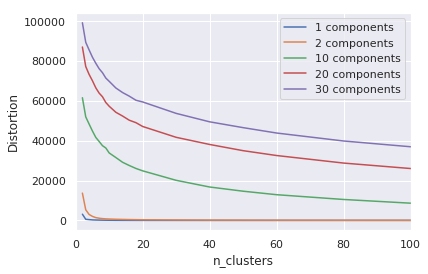

In [109]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.xlim([0,100])
plt.show()

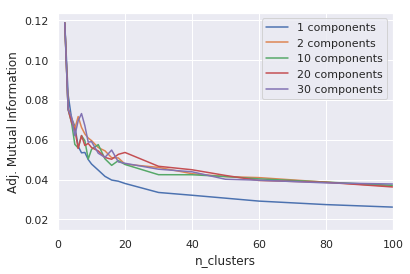

In [65]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.xlim([0, 100])
plt.legend(loc='best')
plt.show()

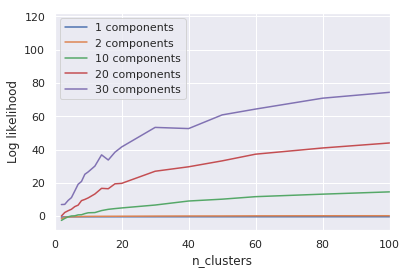

In [78]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
plt.xlim([0, 100])
plt.legend(loc='best')
plt.show()

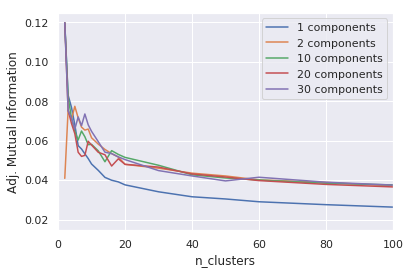

In [85]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.xlim([0,100])
plt.show()

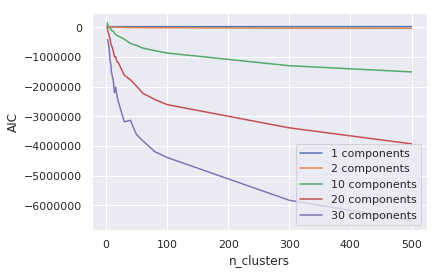

In [81]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

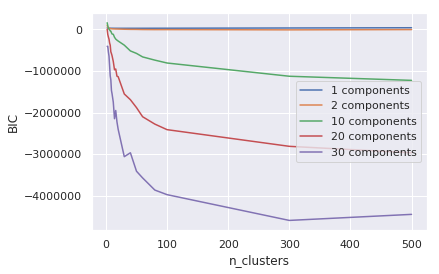

In [144]:
for cc in component_counts:
    plt.plot(n_clusters, [pca_gm_results[cc][k]['bic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('BIC')
plt.xlabel('n_clusters')
plt.show()

## ICA

In [24]:
component_counts = [10,20,30]
# component_counts = [1, 2, 10, 20, 30, 60, 70, 80]
ica_km_results = {}

for cc in component_counts:
    tmp_dr = FastICA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0,
            n_jobs=-1,
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
        tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    ica_km_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset,'km', 'ica%i' % cc)

Doing 10 components
done k=2 in 0.191 sec
done k=3 in 0.347 sec
done k=4 in 0.419 sec
done k=5 in 0.384 sec
done k=6 in 0.489 sec
done k=7 in 0.637 sec
done k=8 in 0.715 sec
done k=9 in 0.719 sec
done k=10 in 0.844 sec
done k=12 in 1.082 sec
done k=14 in 1.262 sec
done k=16 in 1.295 sec
done k=18 in 1.463 sec
done k=20 in 1.743 sec
done k=30 in 2.665 sec
done k=40 in 3.403 sec
done k=50 in 4.219 sec
done k=60 in 4.560 sec
done k=80 in 5.939 sec
done k=100 in 7.483 sec
done k=300 in 15.725 sec
done k=500 in 21.297 sec
Doing 20 components
done k=2 in 0.265 sec
done k=3 in 0.428 sec
done k=4 in 0.569 sec
done k=5 in 0.563 sec
done k=6 in 0.598 sec
done k=7 in 0.806 sec
done k=8 in 0.837 sec
done k=9 in 0.839 sec
done k=10 in 1.023 sec
done k=12 in 1.053 sec
done k=14 in 1.369 sec
done k=16 in 1.531 sec
done k=18 in 1.727 sec
done k=20 in 2.310 sec
done k=30 in 2.900 sec
done k=40 in 3.875 sec
done k=50 in 4.496 sec
done k=60 in 6.006 sec
done k=80 in 6.796 sec
done k=100 in 7.807 sec
done

In [54]:
# component_counts = [1, 2, 10, 20, 30, 60, 70, 80]
component_counts = [1, 2, 10, 20, 30]
ica_km_results = {cc: load_cluster_result(dataset, 'km', 'ica%i' % cc) for cc in component_counts}
ica_gm_results = {cc: load_cluster_result(dataset, 'em', 'ica%i' % cc) for cc in component_counts}

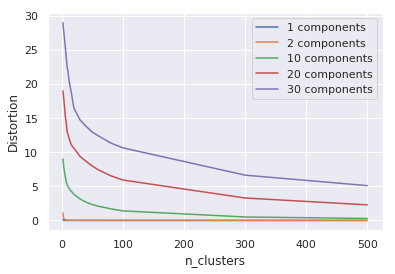

In [55]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.show()

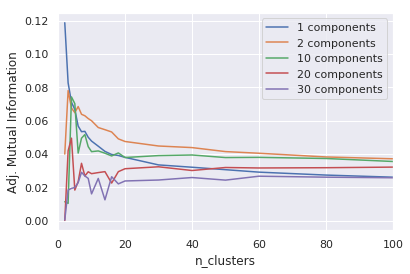

In [56]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.xlim([0, 100])
plt.legend(loc='best')
plt.show()

In [25]:
ica_gm_results = {}

for cc in component_counts:
    tmp_dr = FastICA(n_components=cc, random_state=0)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
        tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    ica_gm_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset, 'em', 'ica%i' % cc)

Doing 10 components
done k=2 in 0.103 sec
done k=3 in 0.132 sec
done k=4 in 0.210 sec
done k=5 in 0.193 sec
done k=6 in 0.255 sec
done k=7 in 0.422 sec
done k=8 in 0.544 sec
done k=9 in 0.652 sec
done k=10 in 0.907 sec
done k=12 in 1.135 sec
done k=14 in 1.381 sec
done k=16 in 2.563 sec
done k=18 in 2.000 sec
done k=20 in 2.114 sec
done k=30 in 2.616 sec
done k=40 in 5.377 sec
done k=50 in 5.350 sec
done k=60 in 6.041 sec
done k=80 in 10.924 sec
done k=100 in 13.510 sec
done k=300 in 28.103 sec
done k=500 in 36.972 sec
Doing 20 components
done k=2 in 0.192 sec
done k=3 in 0.507 sec
done k=4 in 0.513 sec
done k=5 in 0.456 sec
done k=6 in 0.675 sec
done k=7 in 1.458 sec
done k=8 in 0.892 sec
done k=9 in 1.380 sec
done k=10 in 2.598 sec
done k=12 in 2.730 sec
done k=14 in 3.370 sec
done k=16 in 3.189 sec
done k=18 in 4.467 sec
done k=20 in 3.339 sec
done k=30 in 8.663 sec
done k=40 in 12.998 sec
done k=50 in 17.410 sec
done k=60 in 16.591 sec
done k=80 in 26.736 sec
done k=100 in 42.349 s

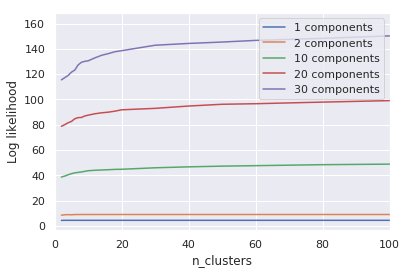

In [58]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
plt.xlim([0, 100])
plt.legend(loc='best')
plt.show()

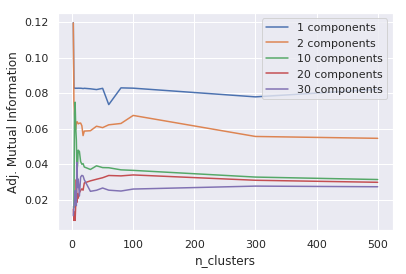

In [60]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

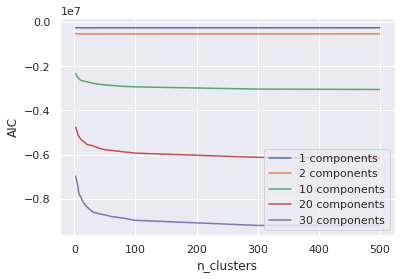

In [61]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

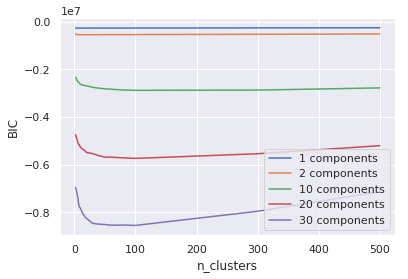

In [62]:
for cc in component_counts:
    plt.plot(n_clusters, [ica_gm_results[cc][k]['bic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('BIC')
plt.xlabel('n_clusters')
plt.show()

## RP

In [174]:
component_counts = [1, 2, 10, 20, 30]


In [146]:
component_counts = [1, 2, 10, 20, 30]
n_clusters = np.hstack((
    np.arange(2, 10),
    np.arange(10, 21, 2),
    np.array([30, 40, 50, 60, 80]),
#     np.array([n_samples/2, n_samples], dtype=np.int)
)).astype(np.int)
rp_km_results = {}

for cc in component_counts:
    tmp_dr = SparseRandomProjection(n_components=cc, random_state=0, eps=None)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0,
            n_jobs=-1,
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    rp_km_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset,'km', 'rp%i' % cc)

Doing 1 components
done k=2 in 0.090 sec
done k=3 in 0.126 sec
done k=4 in 0.145 sec
done k=5 in 0.181 sec
done k=6 in 0.202 sec
done k=7 in 0.228 sec
done k=8 in 0.250 sec
done k=9 in 0.242 sec
done k=10 in 0.288 sec
done k=12 in 0.326 sec
done k=14 in 0.392 sec
done k=16 in 0.425 sec
done k=18 in 0.431 sec
done k=20 in 0.444 sec
done k=30 in 0.777 sec
done k=40 in 1.036 sec
done k=50 in 1.220 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (51) found smaller than n_clusters (60). Possibly due to duplicate points in X.
  return_n_iter=True)


done k=60 in 1.792 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (51) found smaller than n_clusters (80). Possibly due to duplicate points in X.
  return_n_iter=True)


done k=80 in 2.335 sec
Doing 2 components
done k=2 in 0.155 sec
done k=3 in 0.202 sec
done k=4 in 0.192 sec
done k=5 in 0.237 sec
done k=6 in 0.262 sec
done k=7 in 0.248 sec
done k=8 in 0.348 sec
done k=9 in 0.353 sec
done k=10 in 0.381 sec
done k=12 in 0.555 sec
done k=14 in 0.628 sec
done k=16 in 0.768 sec
done k=18 in 1.032 sec
done k=20 in 0.922 sec
done k=30 in 1.867 sec
done k=40 in 1.923 sec
done k=50 in 2.403 sec
done k=60 in 3.021 sec
done k=80 in 4.037 sec
Doing 10 components
done k=2 in 0.289 sec
done k=3 in 0.581 sec
done k=4 in 0.638 sec
done k=5 in 0.789 sec
done k=6 in 0.844 sec
done k=7 in 1.097 sec
done k=8 in 1.141 sec
done k=9 in 1.188 sec
done k=10 in 1.524 sec
done k=12 in 1.832 sec
done k=14 in 2.057 sec
done k=16 in 2.180 sec
done k=18 in 2.956 sec
done k=20 in 3.262 sec
done k=30 in 4.358 sec
done k=40 in 5.441 sec
done k=50 in 6.889 sec
done k=60 in 8.570 sec
done k=80 in 9.587 sec
Doing 20 components
done k=2 in 0.333 sec
done k=3 in 0.563 sec
done k=4 in 0.99

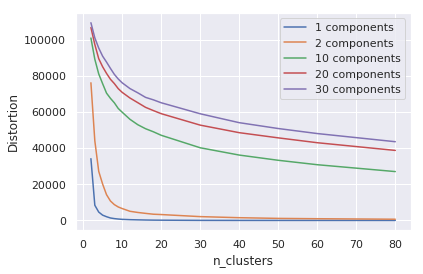

In [147]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.show()

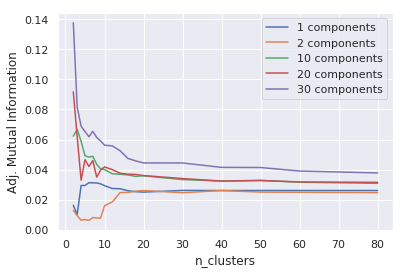

In [149]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

In [150]:
rp_gm_results = {}

for cc in component_counts:
    tmp_dr = SparseRandomProjection(n_components=cc, random_state=0, eps=None)
    tmp_X_tr = tmp_dr.fit_transform(X)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    rp_gm_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset, 'em', 'rp%i' % cc)

Doing 1 components
done k=2 in 0.074 sec
done k=3 in 0.068 sec
done k=4 in 0.117 sec
done k=5 in 0.237 sec
done k=6 in 0.136 sec
done k=7 in 0.187 sec
done k=8 in 0.173 sec
done k=9 in 0.184 sec
done k=10 in 0.444 sec
done k=12 in 0.170 sec
done k=14 in 0.231 sec
done k=16 in 0.548 sec
done k=18 in 0.337 sec
done k=20 in 0.347 sec
done k=30 in 0.484 sec
done k=40 in 0.611 sec
done k=50 in 0.377 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (51) found smaller than n_clusters (60). Possibly due to duplicate points in X.
  return_n_iter=True)


done k=60 in 0.461 sec


/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (51) found smaller than n_clusters (80). Possibly due to duplicate points in X.
  return_n_iter=True)


done k=80 in 0.668 sec
Doing 2 components
done k=2 in 0.079 sec
done k=3 in 0.134 sec
done k=4 in 0.312 sec
done k=5 in 0.556 sec
done k=6 in 0.454 sec
done k=7 in 0.484 sec
done k=8 in 0.651 sec
done k=9 in 0.760 sec
done k=10 in 0.960 sec
done k=12 in 1.327 sec
done k=14 in 1.488 sec
done k=16 in 1.737 sec
done k=18 in 1.739 sec
done k=20 in 2.551 sec
done k=30 in 4.097 sec
done k=40 in 5.928 sec
done k=50 in 7.960 sec
done k=60 in 8.522 sec
done k=80 in 13.595 sec
Doing 10 components
done k=2 in 0.261 sec
done k=3 in 0.281 sec
done k=4 in 0.366 sec
done k=5 in 1.028 sec
done k=6 in 0.931 sec
done k=7 in 1.144 sec
done k=8 in 1.271 sec
done k=9 in 1.204 sec
done k=10 in 1.619 sec
done k=12 in 2.511 sec
done k=14 in 3.416 sec
done k=16 in 3.486 sec
done k=18 in 2.523 sec
done k=20 in 3.527 sec
done k=30 in 7.281 sec
done k=40 in 13.434 sec
done k=50 in 19.683 sec
done k=60 in 13.255 sec
done k=80 in 23.732 sec
Doing 20 components
done k=2 in 0.496 sec
done k=3 in 1.291 sec
done k=4 in

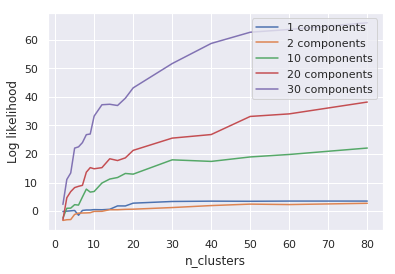

In [175]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
# plt.xlim([0, 100])
plt.legend(loc='best')
plt.show()

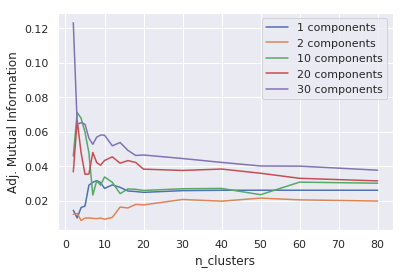

In [151]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

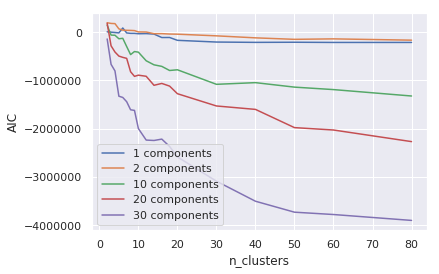

In [167]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='lower left')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

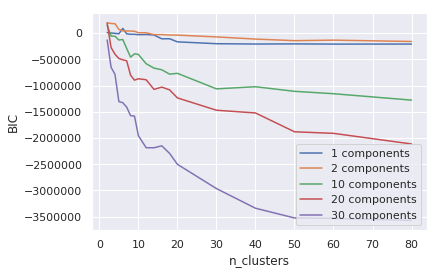

In [153]:
for cc in component_counts:
    plt.plot(n_clusters, [rp_gm_results[cc][k]['bic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('BIC')
plt.xlabel('n_clusters')
plt.show()

## LDA

In [168]:
component_counts = [1]


In [157]:
component_counts = [1]
lda_km_results = {}

for cc in component_counts:
    tmp_dr = LDA(n_components=None)
    tmp_X_tr = tmp_dr.fit_transform(X, y)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    for k in n_clusters:
        km = KMeans(
            n_clusters=k,
            random_state=0,
            n_jobs=-1,
        )
        t0 = time()
        km.fit(tmp_X_tr)
        t = time() - t0
        y_km = km.predict(tmp_X_tr)
        tmp_res[k]['dist'] = km.inertia_
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_km, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_km)
        print('done k=%i in %.3f sec' % (k, t))
    lda_km_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset,'km', 'lda%i' % cc)

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Doing 1 components
done k=2 in 0.173 sec
done k=3 in 0.284 sec
done k=4 in 0.769 sec
done k=5 in 0.594 sec
done k=6 in 0.716 sec
done k=7 in 1.400 sec
done k=8 in 1.294 sec
done k=9 in 1.308 sec
done k=10 in 1.442 sec
done k=12 in 1.544 sec
done k=14 in 2.207 sec
done k=16 in 2.444 sec
done k=18 in 1.937 sec
done k=20 in 2.850 sec
done k=30 in 3.278 sec
done k=40 in 3.829 sec
done k=50 in 4.415 sec
done k=60 in 4.904 sec
done k=80 in 6.880 sec


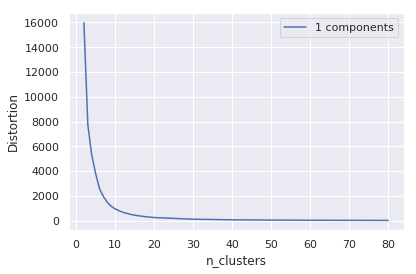

In [158]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_km_results[cc][k]['dist'] for k in n_clusters], label='%i components' % cc)

plt.xlabel('n_clusters')
plt.ylabel('Distortion')
plt.legend(loc='best')
plt.show()

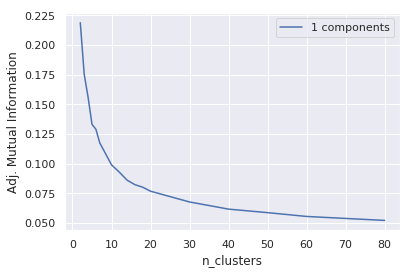

In [159]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_km_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

In [160]:
lda_gm_results = {}

for cc in component_counts:
    tmp_dr = LDA(n_components=None)
    tmp_X_tr = tmp_dr.fit_transform(X, y)
    tmp_res = defaultdict(dict)
    print('Doing %i components' % cc)
    tmp_res = defaultdict(dict)
    for k in n_clusters:
        gm = GaussianMixture(
            n_components=k,
            random_state=0,
            n_init=1,
            init_params='kmeans',
        )
        t0 = time()
        gm.fit(tmp_X_tr)
        t = time() - t0
        y_gm = gm.predict(tmp_X_tr)
        tmp_res[k]['bic'] = gm.bic(tmp_X_tr)
        tmp_res[k]['aic'] = gm.aic(tmp_X_tr)
        tmp_res[k]['ll'] = gm.score(tmp_X_tr)
        tmp_res[k]['time'] = t
#         tmp_res[k]['sil'] = silhouette_score(tmp_X_tr, y_gm, random_state=0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            tmp_res[k]['ami'] = ami(y, y_gm)
        print('done k=%i in %.3f sec' % (k, t))
    lda_gm_results[cc] = tmp_res
    save_cluster_result(tmp_res, dataset, 'em', 'lda%i' % cc)

/Users/wessm/.virtualenvs/pyml/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Doing 1 components
done k=2 in 0.128 sec
done k=3 in 0.112 sec
done k=4 in 0.162 sec
done k=5 in 0.194 sec
done k=6 in 0.175 sec
done k=7 in 0.297 sec
done k=8 in 0.265 sec
done k=9 in 0.424 sec
done k=10 in 0.398 sec
done k=12 in 0.294 sec
done k=14 in 0.447 sec
done k=16 in 0.703 sec
done k=18 in 0.446 sec
done k=20 in 0.426 sec
done k=30 in 0.727 sec
done k=40 in 1.049 sec
done k=50 in 1.227 sec
done k=60 in 1.350 sec
done k=80 in 1.940 sec


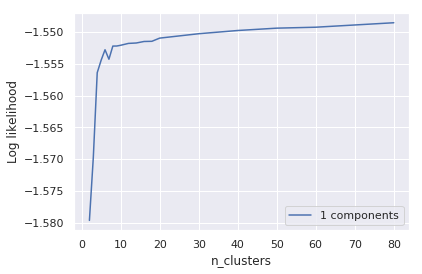

In [169]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['ll'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Log likelihood')
plt.legend(loc='best')
plt.show()

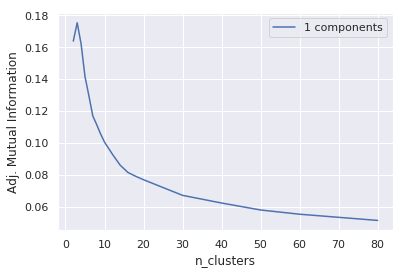

In [162]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['ami'] for k in n_clusters], label='%i components' % cc)
plt.xlabel('n_clusters')
plt.ylabel('Adj. Mutual Information')
plt.legend(loc='best')
plt.show()

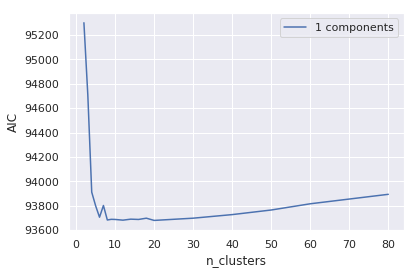

In [163]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['aic'] for k in n_clusters], label='%i components' % cc)
plt.legend(loc='best')
plt.ylabel('AIC')
plt.xlabel('n_clusters')
plt.show()

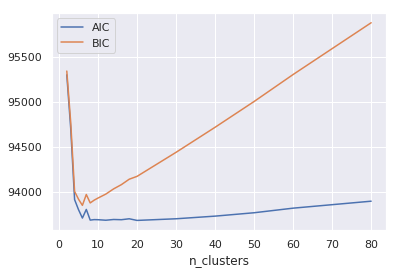

In [172]:
for cc in component_counts:
    plt.plot(n_clusters, [lda_gm_results[cc][k]['aic'] for k in n_clusters], label='AIC')
    plt.plot(n_clusters, [lda_gm_results[cc][k]['bic'] for k in n_clusters], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_clusters')
plt.show()